### Trajectory analysis of Breast Cancer using PILOT-GM-VAE

In this notebook, we demonstrate the entire process of training the model and applying **PILOT-GM-VAE** to single-cell RNA sequencing (scRNA-seq) data using Breast Cancer scRNA data. 
You can download the required AnnData (h5ad) file from the following link:  
[Breast Cancer scRNA Data on Zenodo](https://zenodo.org/records/14615923)

In [3]:
from pilot_gm_vae import *
import scanpy as sc

### Reading Anndata

In [4]:
file_path = 'BreastCncr_processed.h5ad'
adata=sc.read_h5ad(file_path)

### Loading the required information for training the model

In order to work with  PILOT-GM-VAE, ensure that your Anndata object is loaded and contains the required information.
Use the following parameters to configure  PILOT-GM-VAE  for your analysis (Setting Parameters):

adata: Pass your loaded Anndata object to PILOT-GM-VAE.

dataset_name : Name of the dataset for saving the model in the trained_moldes folder.

pca_key: Provide the name of the variable in the obsm level that holds the dimension reduction (PCA representation).

load_weights: Load pre-trained weights if available (if already trained the model set it True).

num_classes: Number of components. (For Breast Cancer, we set this to 10, similar to the number of the cell types in the object.)

You can change other hyperparameters such as the number of epochs, the size of the layers so on.

In [5]:
model = train_gmvae(
    adata=adata,
    dataset_name= "Breast",
    pca_key= 'X_pca_harmony',
    load_weights= True,
    num_classes= 10,
    epochs= 100
)

Loaded pre-trained weights from ./trained_models/Breast/gmvae_weights.pth.
Performing inference...
Done!


#### Loading the pre-estimated distances between samples.
If you train your model, please skip this part and go to the next part (Estimating distances between samples wiht the Wasserstein distance).

In [6]:
adata.uns['EMD']= np.load('trained_models/Breast/EMD.npy')

#### Estimating distances between samples wiht the Wasserstein distance.

Use the following parameters to configure PILOT-GM-VAE for your analysis (Setting Parameters):

adata: Pass your loaded Anndata object to PILOT-GM-VAE.

emb_matrix: Provide the name of the variable in the obsm level that holds the dimension reduction (PCA representation).

sample_col: Indicate the column name in the observation level of your Anndata that contains information about samples or patients.

status: Provide the column name that represents the status or disease (e.g., “control” or “case”).

wass_dis: If you have already computed the disatnces, such the above code that we loaded the EMD, please set this False, otherwise set this True.  


In [7]:
gmmvae_wasserstein_distance(adata,
emb_matrix = 'X_pca_harmony',
sample_col = 'accSample',
status = 'accLabel',
wass_dis= False)

### Trajectory
Here we show the Diffusion map of Wasserstein distance.

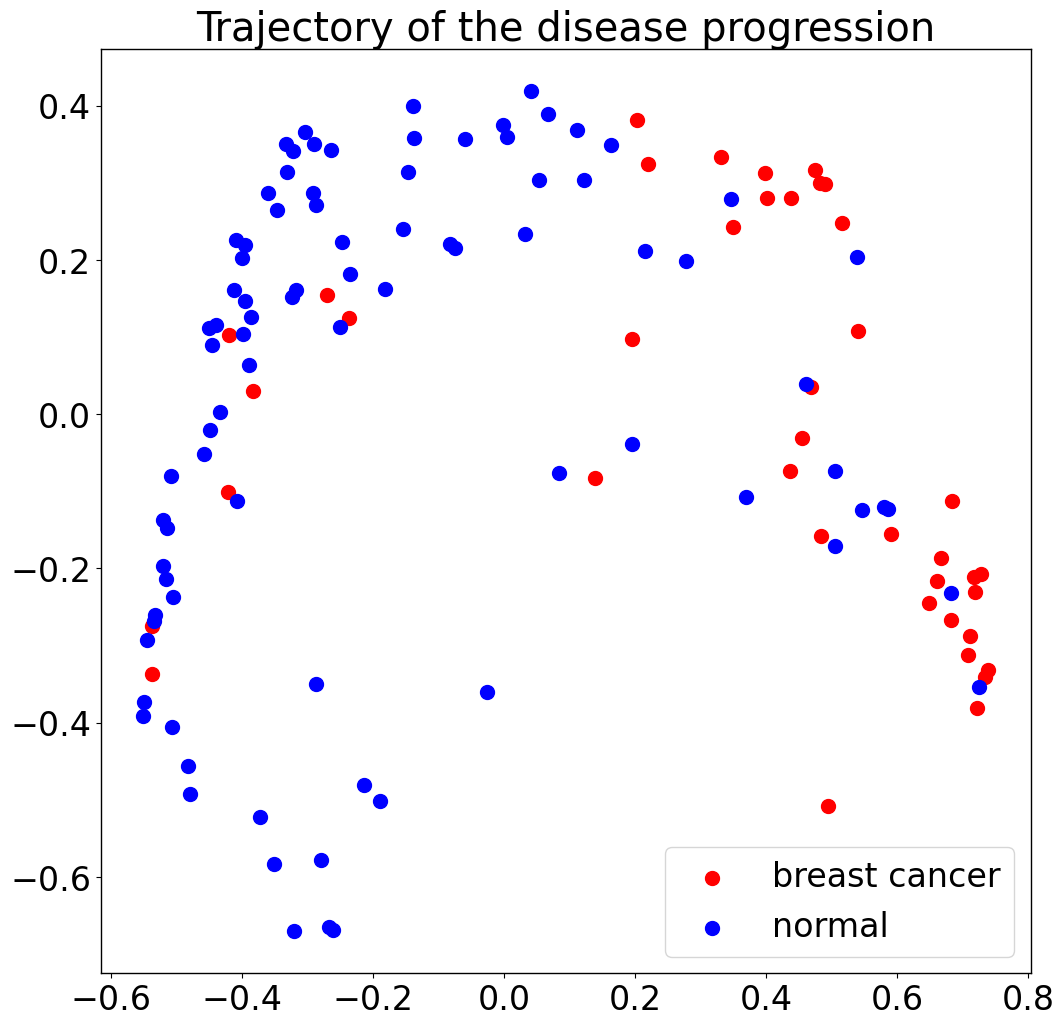

In [9]:
trajectory(adata, colors = ['red','blue','green','yellow','pink'],location_labels= 'best',knn= 8)

#### Fit a principal graph.
The difussion map creates an embedding that potentially reveals a trajectory in the data. Next, PILOT-GM-VAE explores EIPLGraph to find the structure of the trajectory. An important parameter is the source_node, which indicates the start of the trajectory. Here, we selected a normal sample (node with id = 0). This method returns ranked samples, which we define as a disease progression score (t = t1, ..., tn), where tl represents the ranking of the nth sample.

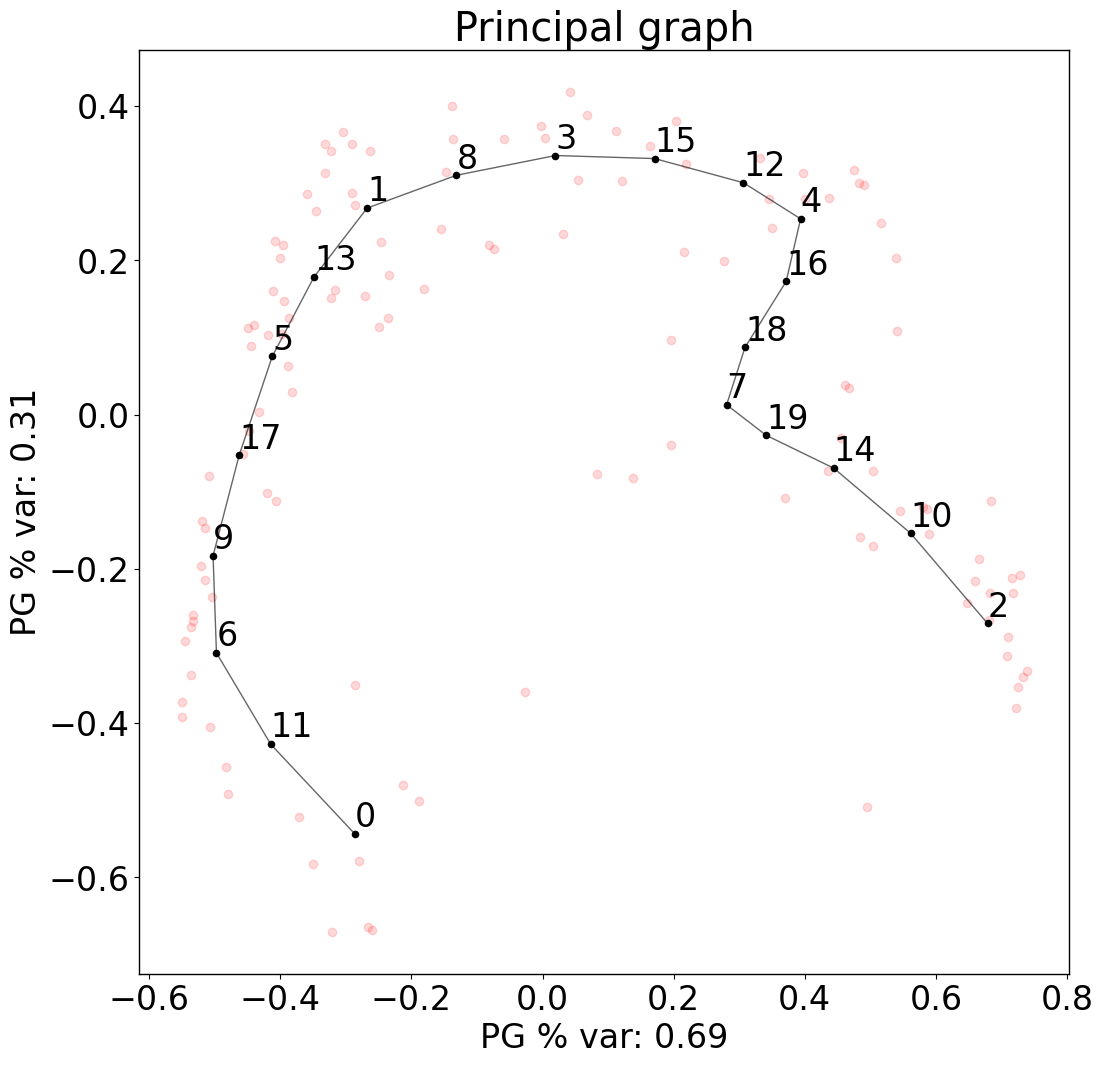

In [10]:
fit_pricipla_graph(adata, source_node = 0)

### Checking the consistency between the found components and the cell types.

Please set the colum name for cell_type_col in your adata for the following function. 

Here, we color the umap based on the found components by the model and the cell types to see how much they match, next we can annotate some of the components which are completely match with cell types. 

As you see in the results, there are perfect matches between almost all components, only two on them are mix of a few cell types. You also see that the compoenets 9 here has a few cell inside that we can remove it as bad qulity cells.



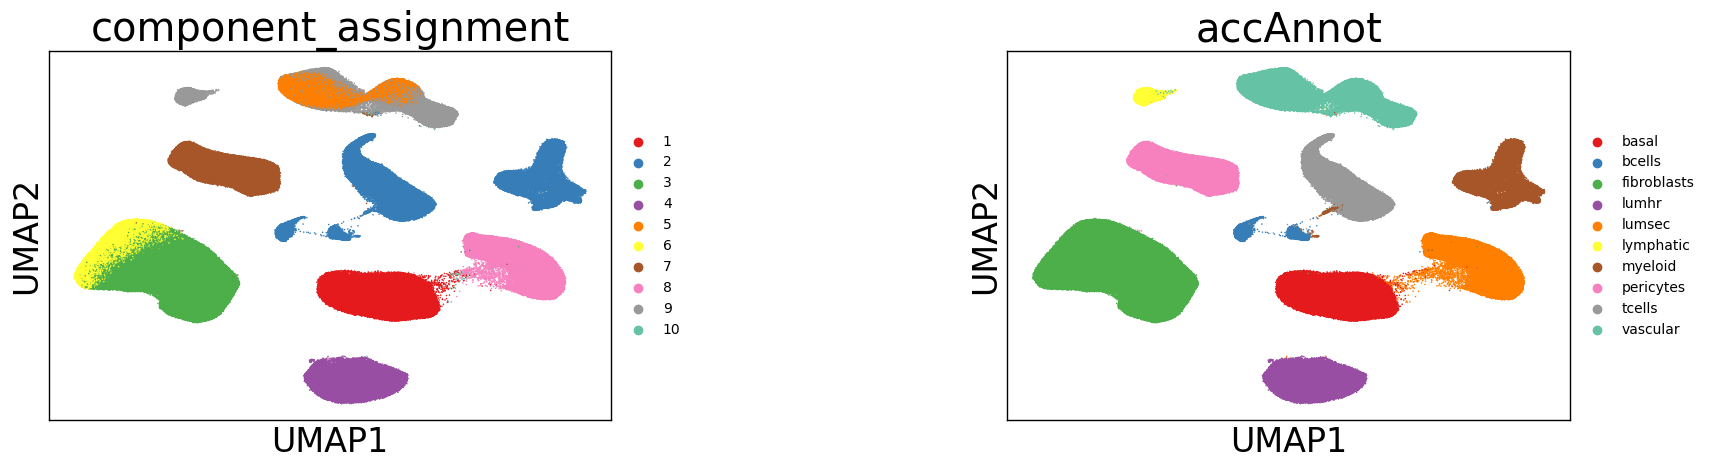

<Figure size 1400x800 with 0 Axes>

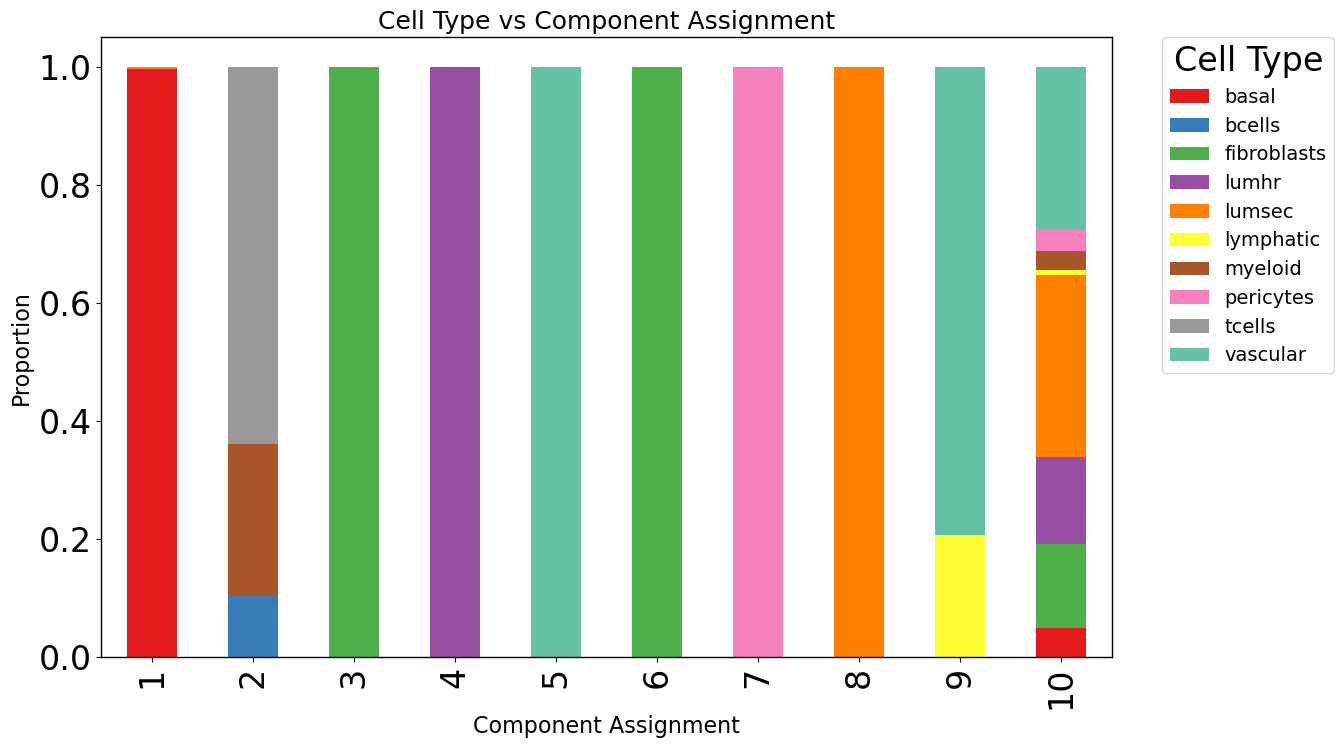

In [11]:
plot_umap_and_stacked_bar(adata,cell_type_col= 'accAnnot')

#### Annotation
Here, based on the previous match by barplots and umap, we can do the following annotaion for the found componenets.

In [12]:
component_to_celltype = {
    '1': 'basal',
    '2': 'immune_cells',
    '3': 'fibroblasts_1',
    '4': 'lumhr',
    '5': 'vascular',
    '6': 'fibroblasts_2',
    '7': 'pericytes',
    '8': 'lumsec',
    '9': 'Endothelial',
    '10':'mix'
}
adata.obs['component_renamed'] = adata.obs['component_assignment'].map(component_to_celltype)

### Component importance
Next, we can use the robust regression model to find components whose proportions change linearly or non-linearly with disease progression. 

In [13]:
gmmvae_wasserstein_distance(adata,
clusters_col= 'component_renamed',
emb_matrix = 'X_pca_harmony',
sample_col = 'accSample',
status = 'accLabel',
wass_dis= False)

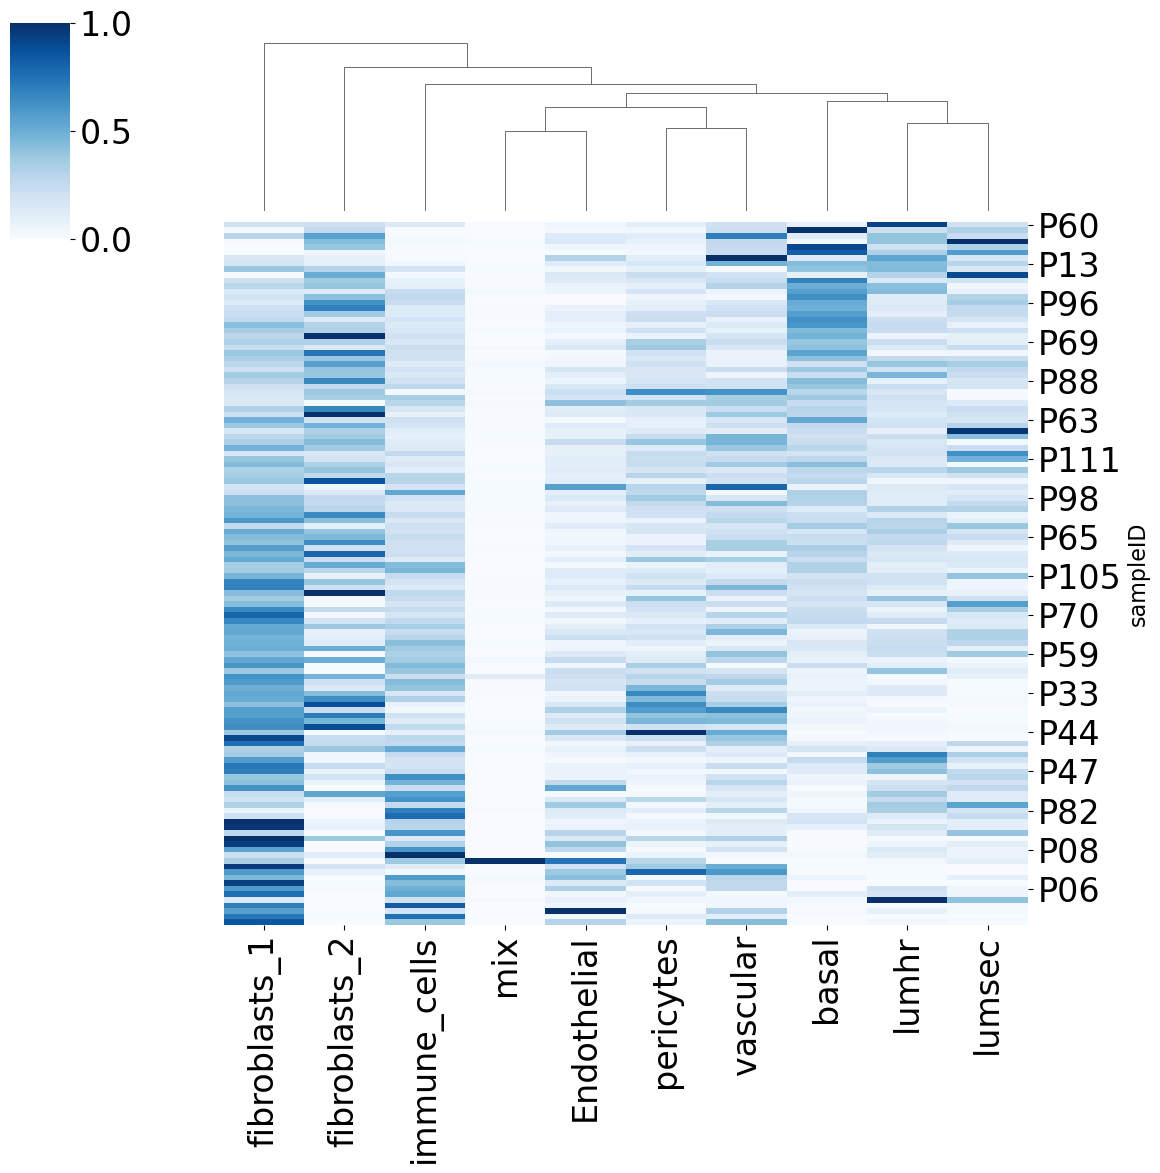

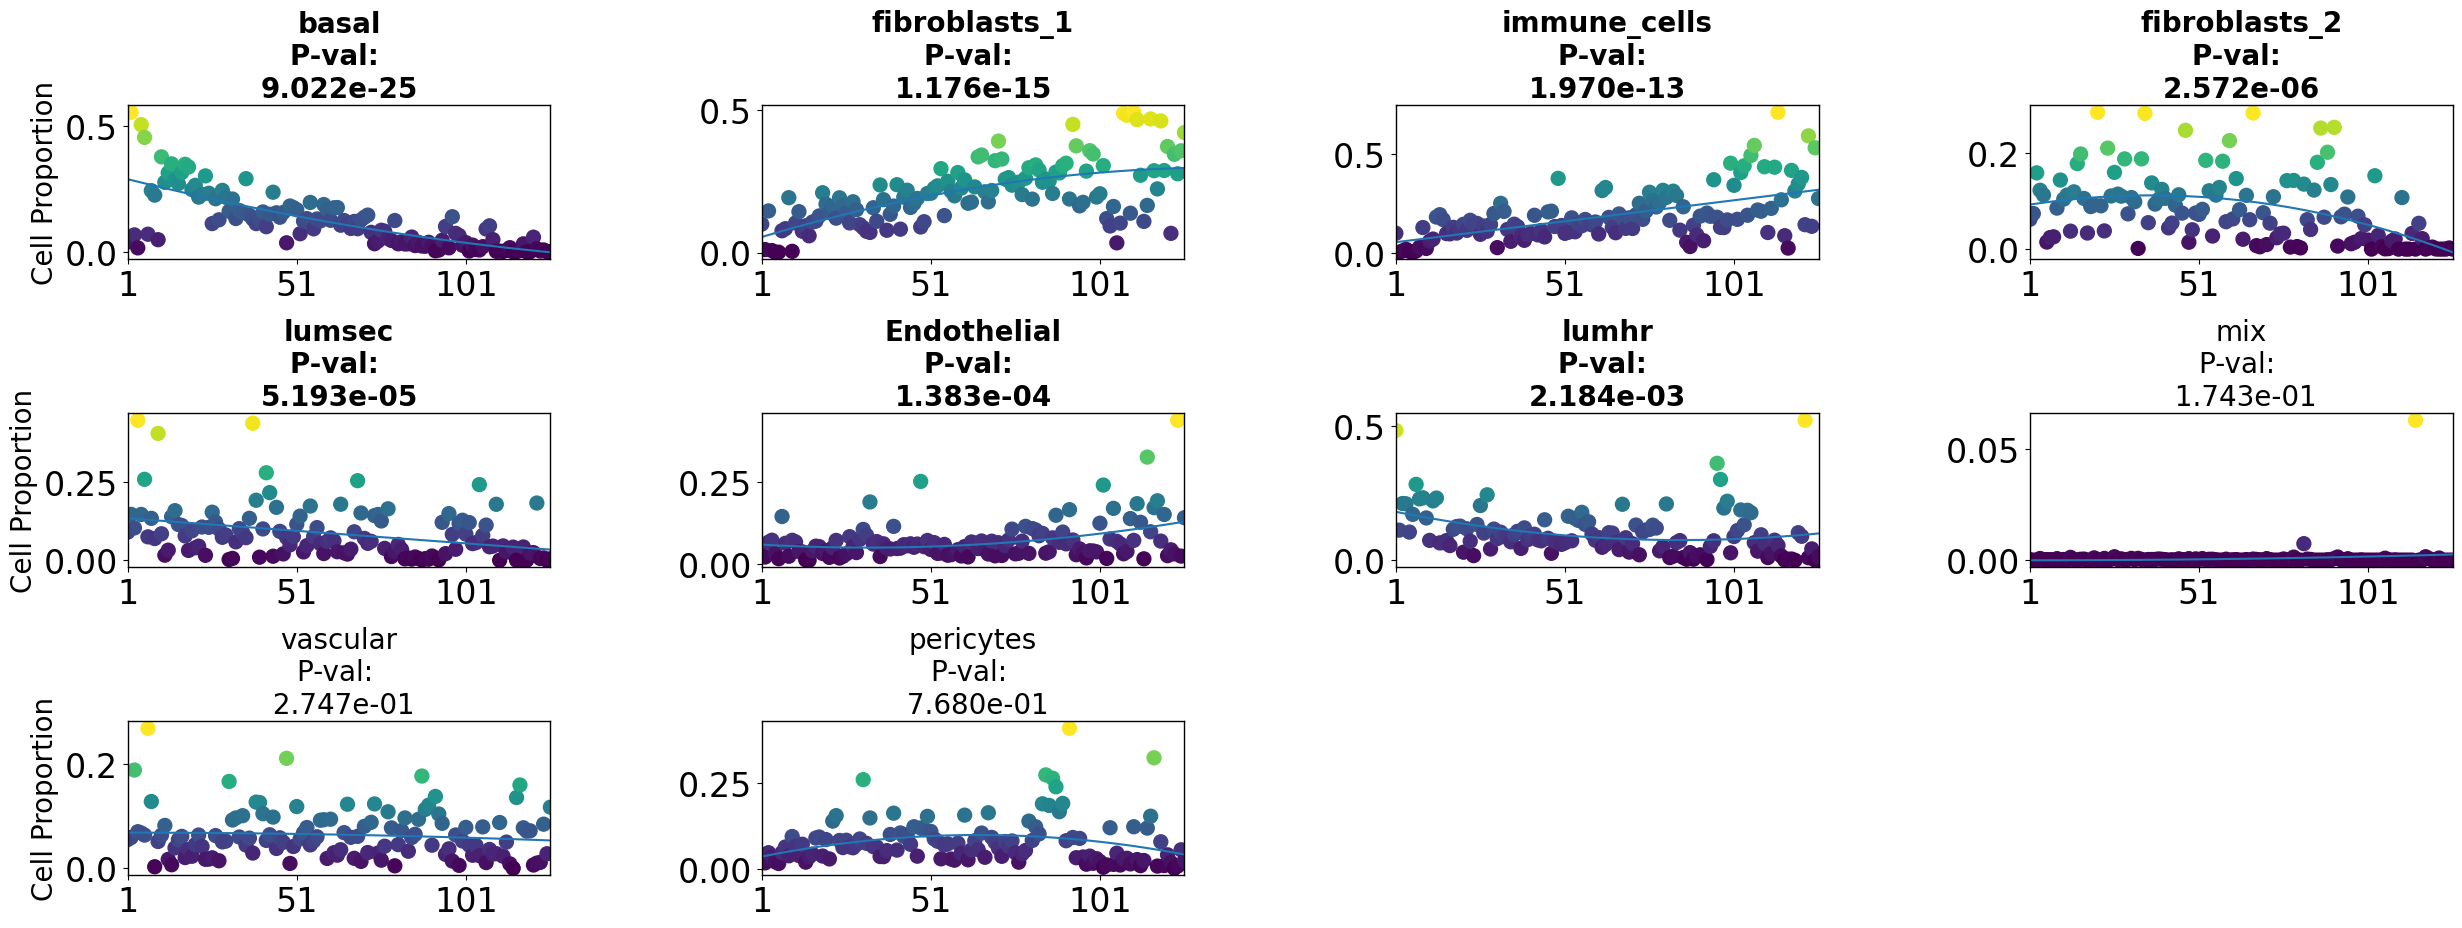

In [14]:
cell_importance(adata,width=30,height=10,xlim=50)

### Applying PILOT-GM-VAE for finding Markers

#### Gene selection: 

Given that we found interesting components, we can investigate genes associated with these trajectories, i.e., genes whose expression changes linearly or quadratically with the disease progression.

After running the command, you can find a folder named ‘Markers’. There, we will have a folder for each cell type. The file ‘Whole_expressions.csv’ contains all statistics associated with genes for that cell type.

Here, we run the genes_importance function for all cell types.

You need to set names of columns that show cell_types/clusters and Samples/Patients in your object.

Note that if you are running this step on a personal computer, this step might take time. So, for this purpose, we first do random sampling. 

In [15]:
filtered_adata = filter_cells_by_sample_and_cell_type(adata, sample_column= 'accSample', cell_type_column= 'component_renamed')

Original number of cells: 714331
Filtered number of cells: 58161


In [16]:
for cell in filtered_adata.obs['component_renamed'].unique():
    genes_importance(filtered_adata,
    name_cell = cell,
    sample_col = 'accSample',
    col_cell = 'component_renamed',
    plot_genes = True, normalize= False,x_lim= 50)

#### Cluster Specific Marker Changes
The previous test only finds genes with significant changes over time for a given cell type. However, it does not consider if a similar pattern and expression values are found in other clusters. To further select genes, we use a Wald test that compares the fit of the gene in the cluster vs. the fit of the gene in other clusters. In the code below, we consider top genes (regarding the regression fit) for all cell types.

In [17]:
gene_cluster_differentiation(filtered_adata,cellnames =['fibroblasts_1','fibroblasts_2'], number_genes = 70)

Test results are saved in ‘gene_clusters_stats_extend.csv’. To find a final list of genes, we only consider genes with a fold change higher than 0.5, i.e. genes which expression is increased in the cluster at hand; and we sort the genes based on the Wald test p-value.
In the following  we show these results beside the GO enrichment for the 50 first top genes of every cell type (FC >= 0.5 and p-value < 0.01) in the following. 

fibroblast_2=pd.read_csv('Results_PILOT/cells/fibroblasts_2_original.csv')
fibroblast_new=fibroblast_2[fibroblast_2['sampleID']!='P116']
fibroblast_new.to_csv('Results_PILOT/cells/fibroblasts_2.csv',index=False)

#### Fibroblasts_1

In [18]:
df=results_gene_cluster_differentiation(cluster_name = 'fibroblasts_1',threshold= 0.5)
df

,gene,cluster,waldStat,pvalue,FC,Expression pattern,fit-pvalue,fit-mod-rsquared
2151,C1R,fibroblasts_1,3186.126544,0.000000e+00,0.844178,linear up,2.263724e-30,0.530693
1242,C3,fibroblasts_1,6097.773752,0.000000e+00,3.539939,linear up,1.739459e-147,0.552095
1034,CTGF,fibroblasts_1,2284.384442,0.000000e+00,1.613504,quadratic down,2.621064e-11,0.537720
1955,GSN,fibroblasts_1,1230.408069,1.851825e-266,1.653654,quadratic up,4.795398e-142,0.586143
2209,COL6A3,fibroblasts_1,1061.273580,3.526714e-231,1.145199,quadratic up,2.026401e-51,0.534161
3530,SELENOP,fibroblasts_1,996.134229,1.240894e-215,1.674885,linear up quadratic down,5.518181e-07,0.516515
1866,SFRP2,fibroblasts_1,640.471545,1.695265e-138,0.779975,linear up quadratic down,5.579741e-44,0.561533
3105,CFD,fibroblasts_1,467.799339,4.534813e-101,3.632682,quadratic up,1.084220e-166,0.647825
1535,ANXA1,fibroblasts_1,391.372626,1.636269e-84,0.660412,linear up,7.242067e-79,0.547995
1722,COL6A2,fibroblasts_1,345.068246,1.743926e-74,1.976507,linear down quadratic up,7.862256e-99,0.555555


#### Clustering genes by pettern :
Here, we cluster the above genes based on the pattern found for each and plot their heatmap. Below the heatmap, we depict the pattern of each group's genes.
You can find curves activities’ statistical scores that show the fold changes of the genes through disease progression in the ‘Markers‘ folder.
Note that you can control the number of clusters using the’ scaler_value’ parameter if you need a wider or more specific one. The default value is 0.5.

Filter genes ...
Cluster genes using hierarchical clustering... 
Compute curves activities... 
Save curves activities... 
Plot the heatmap of genes clustered... 
Heatmap saved as Results_PILOT/Markers/heatmap.pdf


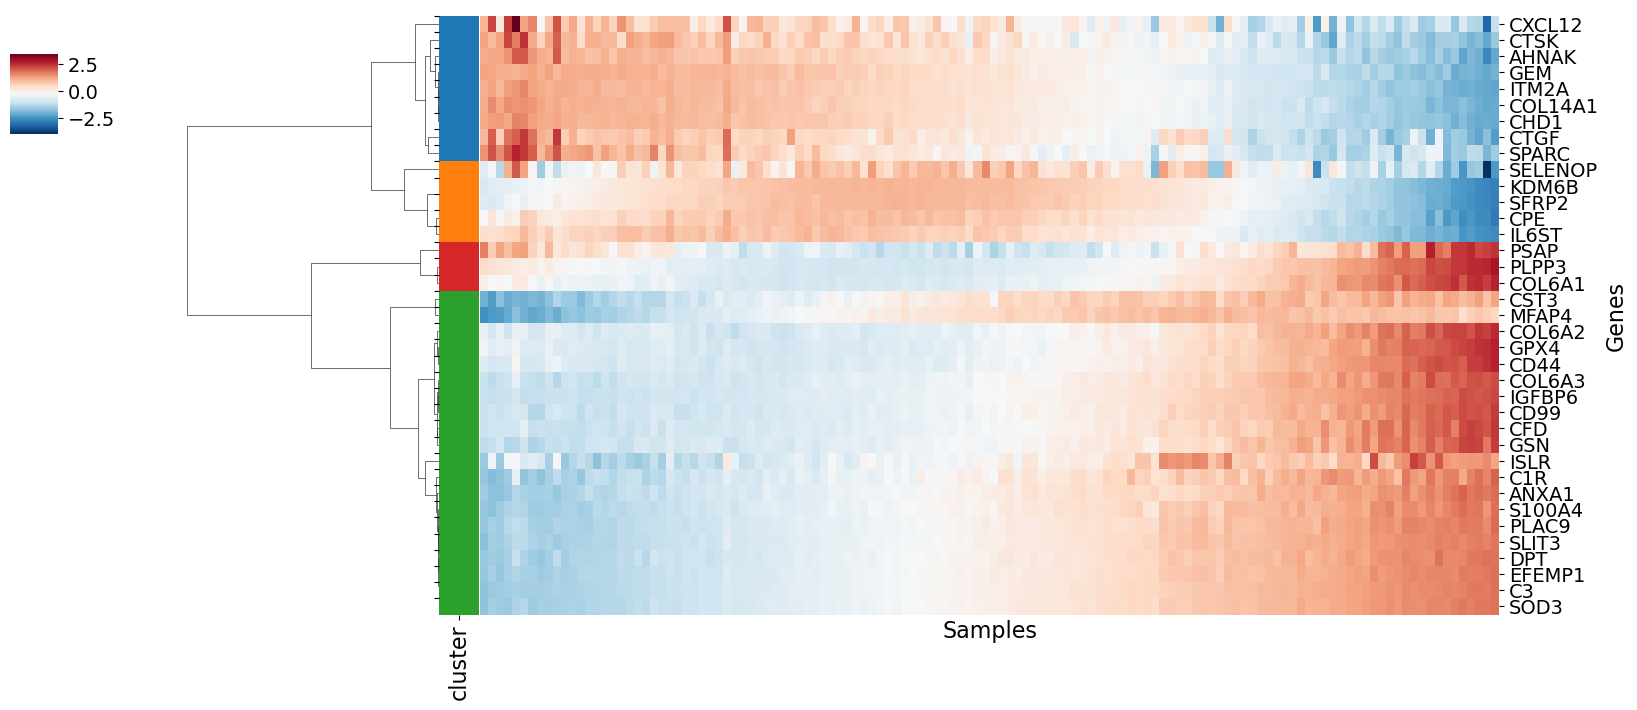

In [16]:
genes_selection_heatmap(filtered_adata, 'fibroblasts_1', scaler_value = 0.5,figsize= (16,8),df=df)

#### Go terms based on Cluters:
Here is the GO enrichment for genes per cluster. Plot and Go terms per cluster are saved at Go/heatmap folder.

Loading existing results for cluster 1...
Loading existing results for cluster 2...
Loading existing results for cluster 4...
Loading existing results for cluster 3...


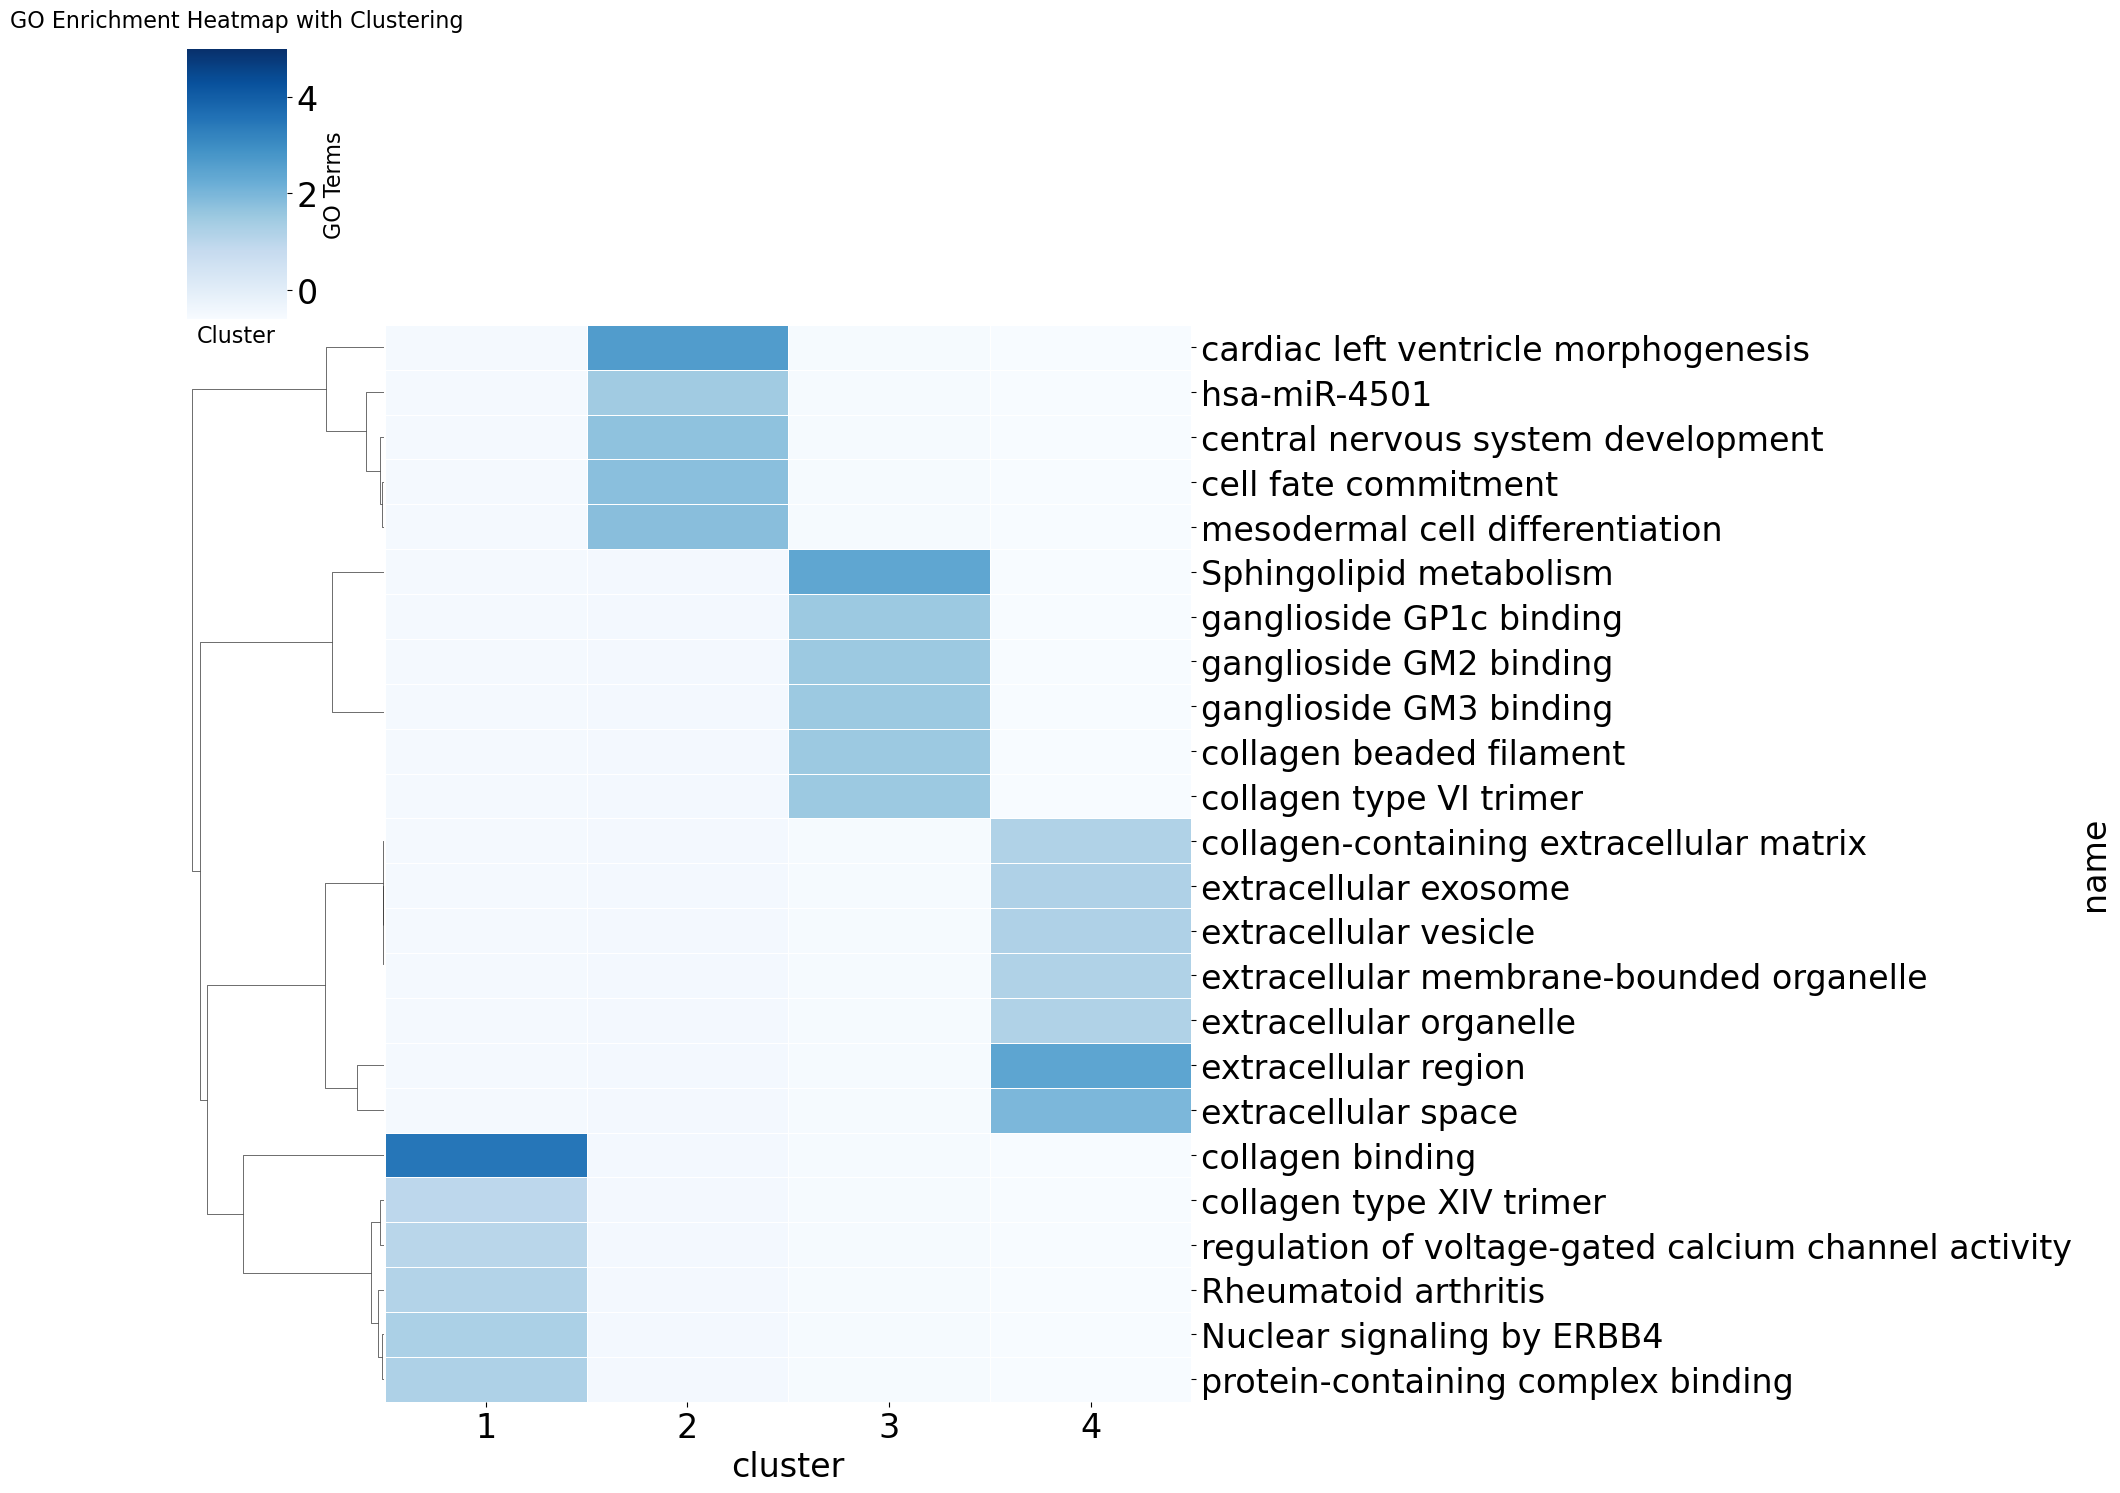

In [27]:
go_enrichment_heatmap(filtered_adata,figsize= (20,15))